In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

np.random.seed(1)

In [6]:
# 处理数据

train_dataset = h5py.File("train_cat.h5", "r") 
test_dataset = h5py.File("test_cat.h5", "r")
    
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 原始数据
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

test_set_x_orig = np.array(test_dataset["test_set_x"][:])
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T # 重塑，一张图片用一个特征向量表示
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_set_x = train_set_x_flatten / 255. #标准化
test_set_x = test_set_x_flatten / 255.

train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # 重塑
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

print('train_set_x:' + str(train_set_x.shape))
print('train_set_y:' + str(train_set_y.shape))
print('test_set_x:' + str(test_set_x.shape))
print('test_set_y:' + str(test_set_y.shape))

train_set_x:(12288, 209)
train_set_y:(1, 209)
test_set_x:(12288, 50)
test_set_y:(1, 50)


In [16]:
# 随机初始化
# 第l层中w的大小为n_l * n_(l-1)，b为n_l * 1

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) 
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1)) # 初始化为0
        
    return parameters

In [9]:
# 正向传播

def sigmoid(Z): # sigmoid函数
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z): # relu函数
    A = np.maximum(0, Z)
    cache = Z 
    
    return A, cache

def linear_activation_forward(A_prev, W, b, activation): # 单层模型
    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)
    
    if activation == "sigmoid": 
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters): # L层模型
    caches = []
    A = X
    L = len(parameters) // 2                 

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches

def compute_cost(AL, Y): # 计算成本
    m = Y.shape[1]

    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)) # 成本函数
    cost = np.squeeze(cost)

    return cost

In [10]:
# 反向传播

def sigmoid_backward(dA, cache): # sigmoid单元求导
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

def relu_backward(dA, cache): # relu单元求导
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    return dZ

def linear_activation_backward(dA, cache, activation): # 单层
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches): # L层
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate): # 更新参数
    L = len(parameters) // 2 

    for l in range(L): 
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]

    return parameters

In [11]:
# 计算准确度

def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("预测准确度: "  + str(np.sum((p == y)/m)))
        
    return p

In [12]:
# L层神经网络

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                  
    
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
                
        if print_cost and i % 100 == 0:
            print ("循环%i次后的成本值: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

循环0次后的成本值: 0.771749
循环100次后的成本值: 0.672053
循环200次后的成本值: 0.648263
循环300次后的成本值: 0.611507
循环400次后的成本值: 0.567047
循环500次后的成本值: 0.540138
循环600次后的成本值: 0.527930
循环700次后的成本值: 0.465477
循环800次后的成本值: 0.369126
循环900次后的成本值: 0.391747
循环1000次后的成本值: 0.315187
循环1100次后的成本值: 0.272700
循环1200次后的成本值: 0.237419
循环1300次后的成本值: 0.199601
循环1400次后的成本值: 0.189263
循环1500次后的成本值: 0.161189
循环1600次后的成本值: 0.148214
循环1700次后的成本值: 0.137775
循环1800次后的成本值: 0.129740
循环1900次后的成本值: 0.121225
循环2000次后的成本值: 0.113821
循环2100次后的成本值: 0.107839
循环2200次后的成本值: 0.102855
循环2300次后的成本值: 0.100897
循环2400次后的成本值: 0.092878


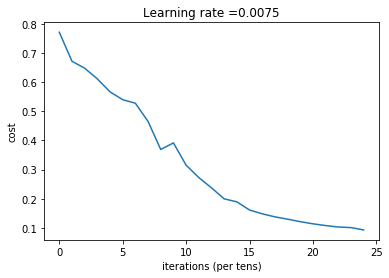

预测准确度: 0.9856459330143539
预测准确度: 0.8


In [15]:
layers_dims = [12288, 20, 7, 5, 1]
parameters = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 2500, print_cost = True)

pred_train = predict(train_set_x, train_set_y, parameters)
pred_test = predict(test_set_x, test_set_y, parameters)

In [ ]:
e